In [53]:
import pandas as pd
import numpy as np

# --- CARICAMENTO ---
df = pd.read_csv("/Users/GeorgKhella/Desktop/Financial Statements.csv")

# --- PULIZIA NOMI COLONNE ---
df.columns = df.columns.str.strip().str.replace(" ", "_")

# --- SELEZIONE VARIABILI CHIAVE ---
df_extra = df[['Company','Year','Revenue','EBITDA','Net_Income']].copy()

# Ordiniamo per azienda-anno
df_extra = df_extra.sort_values(['Company','Year'])

# --- CREAZIONE LAG ---
for col in ['Revenue','EBITDA','Net_Income']:
    df_extra[f'{col}_lag1'] = df_extra.groupby('Company')[col].shift(1)

# Pulizia valori mancanti
df_extra = df_extra.dropna()

# --- LOG SOLO SU REVENUE ---
df_extra['logRev'] = np.log1p(df_extra['Revenue'])
df_extra['logRev_lag1'] = np.log1p(df_extra['Revenue_lag1'])

print("✅ Dataset pronto")
print(df_extra.head())


✅ Dataset pronto
   Company  Year   Revenue   EBITDA  Net_Income  Revenue_lag1  EBITDA_lag1  \
12    AAPL  2010   65225.0  19412.0     14013.0       42905.0      12474.0   
11    AAPL  2011  108249.0  35604.0     25922.0       65225.0      19412.0   
10    AAPL  2012  156508.0  58518.0     41733.0      108249.0      35604.0   
9     AAPL  2013  170910.0  55756.0     37037.0      156508.0      58518.0   
8     AAPL  2014  182795.0  60449.0     39510.0      170910.0      55756.0   

    Net_Income_lag1     logRev  logRev_lag1  
12           8235.0  11.085613    10.666767  
11          14013.0  11.592199    11.085613  
10          25922.0  11.960869    11.592199  
9           41733.0  12.048898    11.960869  
8           37037.0  12.116126    12.048898  


In [51]:
for company, model in results_multi.items():
    print(f"\n=== {company} ===")
    print(model.summary())



=== AAPL ===
                            OLS Regression Results                            
Dep. Variable:                 logRev   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     91.22
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           4.68e-07
Time:                        17:31:34   Log-Likelihood:                 13.840
No. Observations:                  13   AIC:                            -19.68
Df Residuals:                       9   BIC:                            -17.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2434  

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [55]:
import statsmodels.formula.api as smf

# modello panel con effetti fissi per azienda
model = smf.ols(
    formula="logRev ~ logRev_lag1 + EBITDA_lag1 + Net_Income_lag1 + C(Company)",
    data=df_extra
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 logRev   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1204.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):          2.02e-133
Time:                        17:31:49   Log-Likelihood:                 139.73
No. Observations:                 149   AIC:                            -249.5
Df Residuals:                     134   BIC:                            -204.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0661    

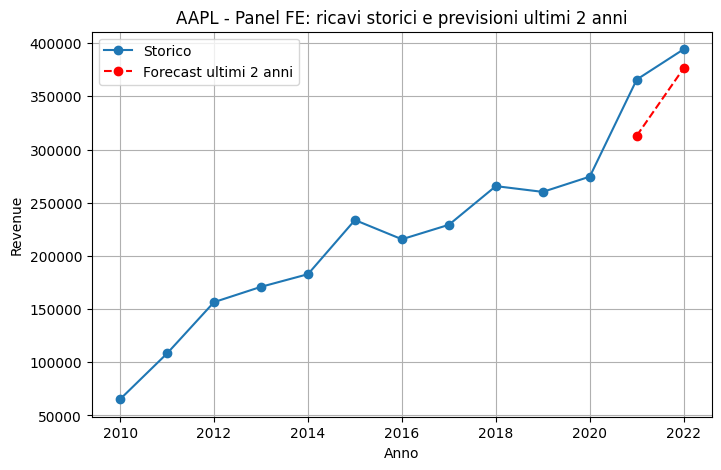

   Year     Reale       Previsto
1  2021  365817.0  313015.044389
0  2022  394328.0  376522.268315


In [77]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def panel_forecast(company, df_extra):
    # Split: tieni fuori gli ultimi 2 anni dell'azienda target
    group = df_extra[df_extra["Company"] == company]
    cutoff = group["Year"].max() - 2
    df_train = df_extra[~((df_extra["Company"] == company) & (df_extra["Year"] > cutoff))]
    df_test = df_extra[(df_extra["Company"] == company) & (df_extra["Year"] > cutoff)]

    # Stima modello FE su train
    model = smf.ols(
        formula="logRev ~ logRev_lag1 + EBITDA_lag1 + Net_Income_lag1 + C(Company)",
        data=df_train
    ).fit()

    # Previsioni per test
    preds = model.predict(df_test)

    # Torno in scala revenue
    preds_revenue = np.expm1(preds)

    # --- Plot ---
    plt.figure(figsize=(8,5))
    plt.plot(group["Year"], group["Revenue"], marker="o", label="Storico")
    plt.plot(df_test["Year"], preds_revenue, marker="o", linestyle="--", color="red", label="Forecast ultimi 2 anni")
    plt.title(f"{company} - Panel FE: ricavi storici e previsioni ultimi 2 anni")
    plt.xlabel("Anno")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tabella confronto
    return pd.DataFrame({
        "Year": df_test["Year"].values,
        "Reale": df_test["Revenue"].values,
        "Previsto": preds_revenue
    })

# ESEMPIO con AAPL
aapl_panel_results = panel_forecast("AAPL", df_extra)
print(aapl_panel_results)


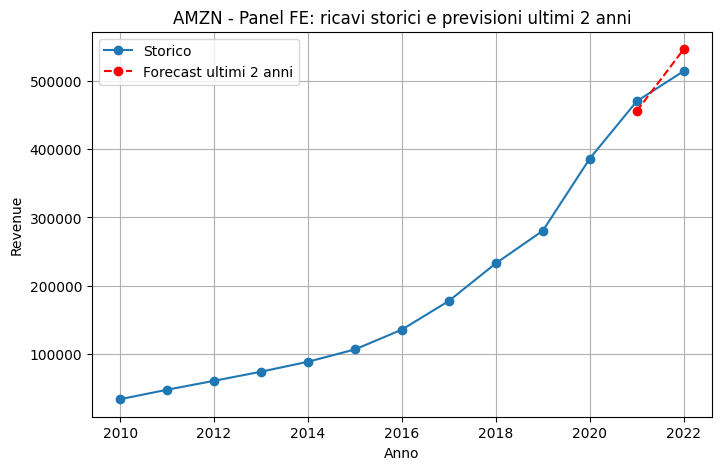

     Year     Reale       Previsto
148  2021  469822.0  455511.099574
147  2022  513983.0  545923.935788


In [80]:
amzn_panel_results = panel_forecast("AMZN", df_extra)
print(amzn_panel_results)

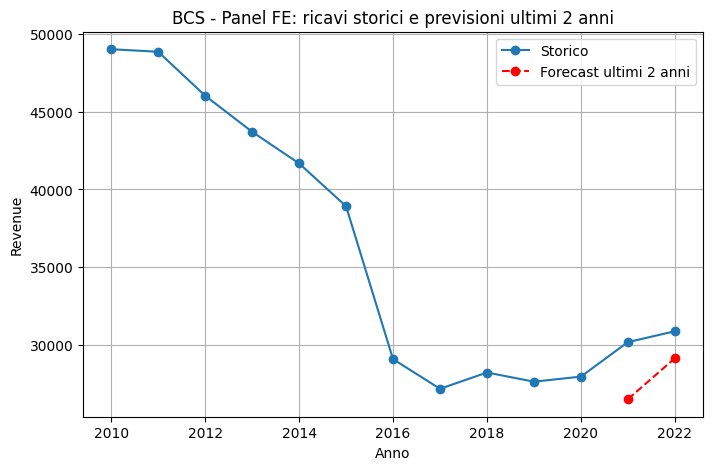

     Year     Reale      Previsto
105  2021  30169.69  26491.669557
104  2022  30868.08  29129.079388


In [82]:
bcs_panel_results = panel_forecast("BCS", df_extra)
print(bcs_panel_results)

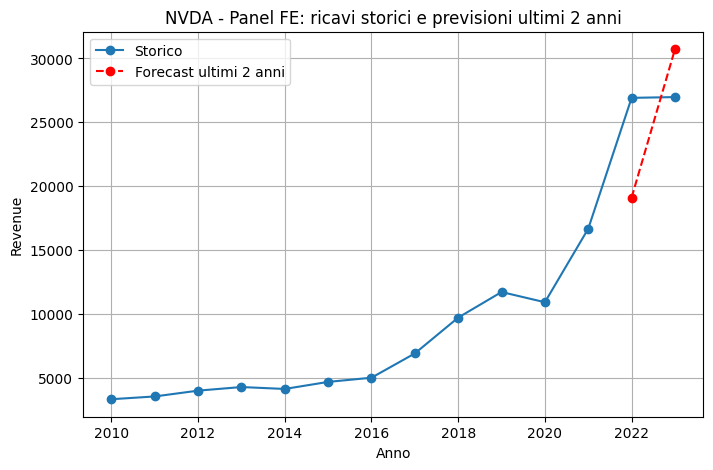

     Year    Reale      Previsto
119  2022  26914.0  19112.438723
118  2023  26974.0  30720.299488


In [84]:
nvda_panel_results = panel_forecast("NVDA", df_extra)
print(nvda_panel_results)